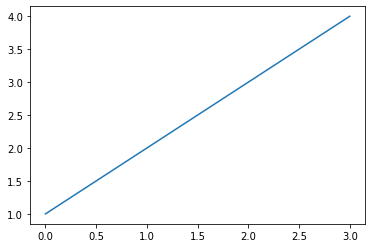

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4])

import math
import torch
from torch import nn, Tensor
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchsummary import summary



import pandas as pd
import numpy as np
import time

from models import ensembleModel

import sys
from quantnote import BacktestEngine, Strategy


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ensemble_model_18 = ensembleModel().to(device)
ensemble_model_19 = ensembleModel().to(device)
ensemble_model_20 = ensembleModel().to(device)
ensemble_model_21 = ensembleModel().to(device)

checkpoint = torch.load('checkpoint_18.pt')
ensemble_model_18.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load('checkpoint_19.pt')
ensemble_model_19.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load('checkpoint_20.pt')
ensemble_model_20.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load('checkpoint_21.pt')
ensemble_model_21.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
engine = BacktestEngine('MainDB_500.db')

Loading DB...
DB loaded in 49.72 seconds
[initialize] is executed in 57.14 seconds


In [5]:
df_merge = pd.read_parquet('df_merge.parquet')

def layer_norm(arr):
    for idx in range(arr.shape[1]):
        arr_1d = arr[:,idx]
        mean = np.mean(arr_1d)
        std = np.std(arr_1d)
        arr[:,idx] = (arr_1d-mean)/(0.001+std)
    return arr

def get_score(ticker, date, model):
    try:
        df = df_merge[(df_merge.ticker==ticker)].set_index('date').loc[:date].iloc[-60:]
        df = df[df.columns[2:]].reset_index(drop=True)
        df['index'] = df.index

        df_arr = np.array([layer_norm(df.values)])


        tensor = torch.tensor(df_arr)
        tensor = tensor.type(torch.cuda.FloatTensor)


        model.eval()
        with torch.no_grad():
            output = model(tensor).cpu().numpy()[0,0]

        
    except:
        output = np.nan

    return output

In [6]:
class myStrategy(Strategy):
    def __init__(self, weighting):
        super().__init__()
        self.weighting = weighting

    def compute_target(self, universe_list):
        target_weight = { }
        
        year = pd.to_datetime(self.date).year
        if year == 2018:
            model = ensemble_model_18
        elif year == 2019:
            model = ensemble_model_19
        elif year == 2020:
            model = ensemble_model_20
        elif year == 2021:
            model = ensemble_model_21
            
        model.eval()
        
        for ticker in universe_list:
            try:
                alpha = get_score(ticker, self.date, model)
                if alpha > 0:
                    if self.weighting == 'CW':
                        target_weight[ticker] = self.get_value('metric',ticker,'marketcap')
                    elif self.weighting == 'EW':
                        target_weight[ticker] = 1
                    elif self.weighting == 'FW':
                        target_weight[ticker] = alpha
            except:
                pass
        
            
        target_weight = self.normalize(target_weight)
        return target_weight

    def custom_factor(self, ticker, ftype):
        if ftype == 'marketcap':
            return self.get_value('metric',ticker,'marketcap')
        elif ftype == 'model':
            alpha = get_score(ticker, self.date, ensemble_model)
            return alpha
        else:
            assert False

capWeight = myStrategy(weighting='CW')
equalWeight = myStrategy(weighting='EW')
factorWeight = myStrategy(weighting='FW')

Backtest period: 2018-01-03 00:00:00 -- 2021-08-31 00:00:00


C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\torch\nn\functional.py:1847: UserWarning: An output with one or more elements was resized since it had shape [1, 1024], w

=== date:2021-08-31 00:00:00 / total_asset:2.004 / time elapsed:393.9 ===
[run_backtest] is executed in 394.24 seconds


/Users/earen/Documents/quantsailor/quantnote\quantnote\backtest_engine.py:348: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


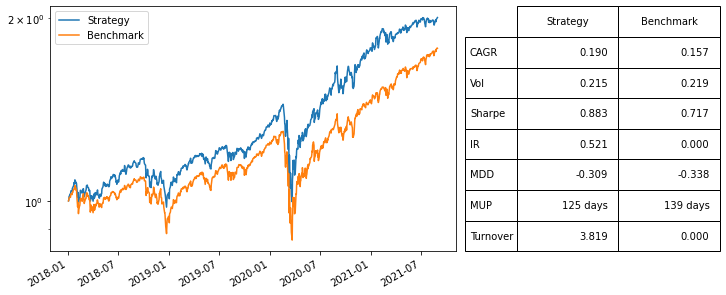

In [7]:
engine.run_backtest(capWeight, '2018-01-02', '2021-08-31')
engine.show_report()

Backtest period: 2018-01-03 00:00:00 -- 2021-08-31 00:00:00


C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\torch\nn\functional.py:1847: UserWarning: An output with one or more elements was resized since it had shape [1, 1024], w

=== date:2021-08-31 00:00:00 / total_asset:1.903 / time elapsed:396.1 ===
[run_backtest] is executed in 396.57 seconds


/Users/earen/Documents/quantsailor/quantnote\quantnote\backtest_engine.py:348: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


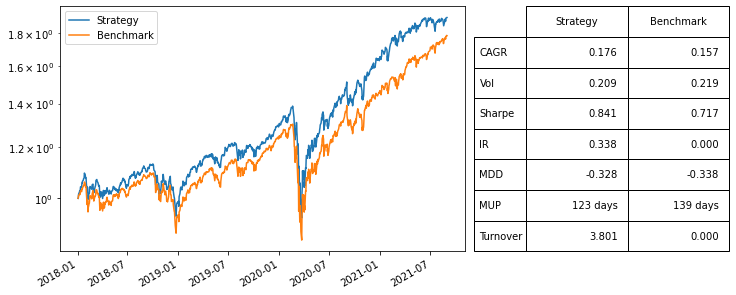

In [8]:
engine.run_backtest(equalWeight, '2018-01-02', '2021-08-31')
engine.show_report()

Backtest period: 2018-01-03 00:00:00 -- 2021-08-31 00:00:00


C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\earen\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\earen\Anaconda3\lib\site-packages\torch\nn\functional.py:1847: UserWarning: An output with one or more elements was resized since it had shape [1, 1024], w

=== date:2021-08-31 00:00:00 / total_asset:2.056 / time elapsed:393.0 ===
[run_backtest] is executed in 393.42 seconds


/Users/earen/Documents/quantsailor/quantnote\quantnote\backtest_engine.py:348: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


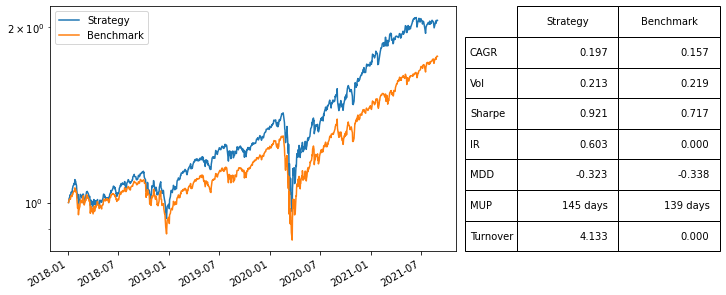

In [9]:
engine.run_backtest(factorWeight, '2018-01-02', '2021-08-31')
engine.show_report()